In [10]:
import zipfile
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from PIL import Image
from functools import reduce

In [2]:
IMG_WIDTH = 32
IMG_HEIGHT = 32

In [3]:
def reduce_file_into_data(data, filename, zfile):
    try:
        label = int(re.match(r"gtsrb/(\d+)/.*?.ppm", filename).group(1))
    except AttributeError:
        return data

    with zfile.open(filename) as file:
        img = np.array(Image.open(file).resize((IMG_WIDTH, IMG_HEIGHT)))

    X, y = data

    X.append(img)
    y.append(label)

    return data


with zipfile.ZipFile("./gtsrb.zip") as zfile:
    X, y = reduce(
        lambda *args: reduce_file_into_data(*args, zfile), zfile.namelist(), ([], [])
    )

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X), np.array(y), test_size=0.1, random_state=0
)

In [11]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.Conv2D(
            filters=6,
            kernel_size=5,
            activation="relu",
        ),
        keras.layers.AvgPool2D(
            pool_size=2,
            strides=2,
        ),
        keras.layers.Conv2D(
            filters=16,
            kernel_size=5,
            activation="relu",
        ),
        keras.layers.AvgPool2D(
            pool_size=2,
            strides=2,
        ),
        keras.layers.Conv2D(
            filters=120,
            kernel_size=5,
            activation="relu",
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(84, activation="relu"),
        keras.layers.Dense(len(set(y_train)), activation="softmax"),
    ]
)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         4

In [7]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    X_train,
    keras.utils.to_categorical(y_train),
    epochs=20,
    batch_size=64,
)

Epoch 1/20
375/375 [==============================] - 3s 8ms/step - loss: 2.0347 - accuracy: 0.4646
Epoch 2/20
375/375 [==============================] - 3s 8ms/step - loss: 0.6871 - accuracy: 0.8104
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.4365 - accuracy: 0.8803
Epoch 4/20
375/375 [==============================] - 3s 9ms/step - loss: 0.3113 - accuracy: 0.9172
Epoch 5/20
375/375 [==============================] - 3s 8ms/step - loss: 0.2439 - accuracy: 0.9351
Epoch 6/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1882 - accuracy: 0.9505
Epoch 7/20
375/375 [==============================] - 4s 9ms/step - loss: 0.1518 - accuracy: 0.9585
Epoch 8/20
375/375 [==============================] - 3s 9ms/step - loss: 0.1244 - accuracy: 0.9662
Epoch 9/20
375/375 [==============================] - 4s 10ms/step - loss: 0.1018 - accuracy: 0.9723
Epoch 10/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0878 - accuracy: 0.976

In [8]:
model.evaluate(
    X_test,
    keras.utils.to_categorical(y_test),
)

84/84 [==============================] - 1s 5ms/step - loss: 0.0932 - accuracy: 0.9831


[0.09318725019693375, 0.9831081032752991]

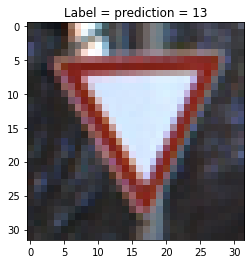

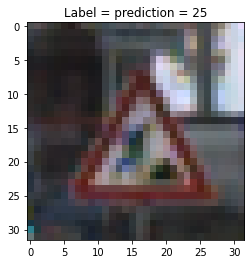

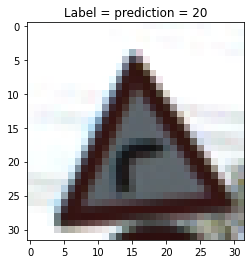

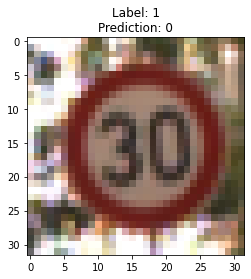

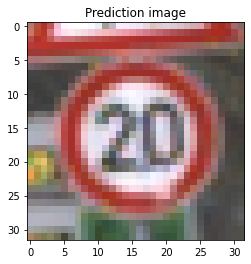

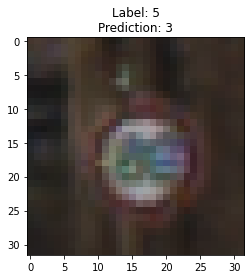

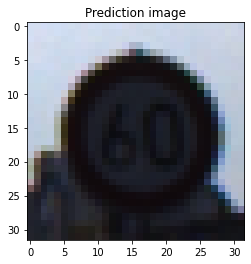

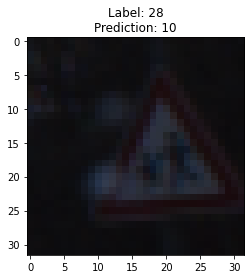

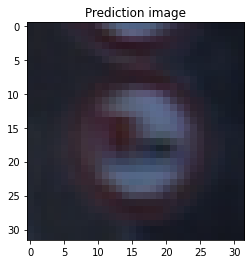

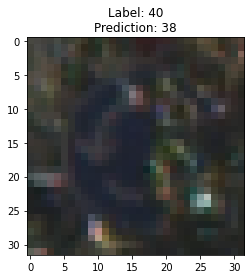

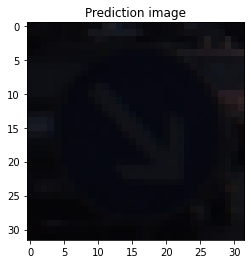

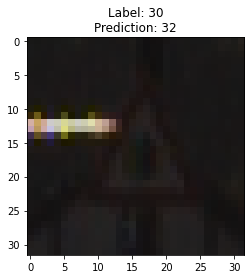

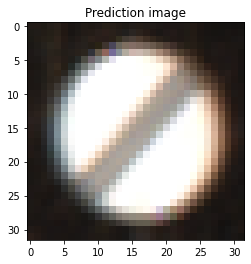

In [9]:
predictions = [pred.argmax() for pred in model.predict(X_test, verbose=0)]

correctly_classified = (predictions == y_test).nonzero()[0]
incorrectly_classified = np.where(predictions != y_test)[0]

for _ in range(3):
    random_index = np.random.choice(correctly_classified)
    plt.imshow(X_test[random_index])
    plt.title(f"Label = prediction = {predictions[random_index]}")
    plt.show()

for _ in range(5):
    random_index = np.random.choice(incorrectly_classified)
    plt.imshow(X_test[random_index])
    plt.title(f"Label: {y_test[random_index]}\nPrediction: {predictions[random_index]}")
    plt.show()

    try:
        pred_img = np.where(y_test == predictions[random_index])[0][0]
        plt.imshow(X_test[pred_img])
        plt.title("Prediction image")
        plt.show()
    except IndexError:
        print("No image for this prediction")